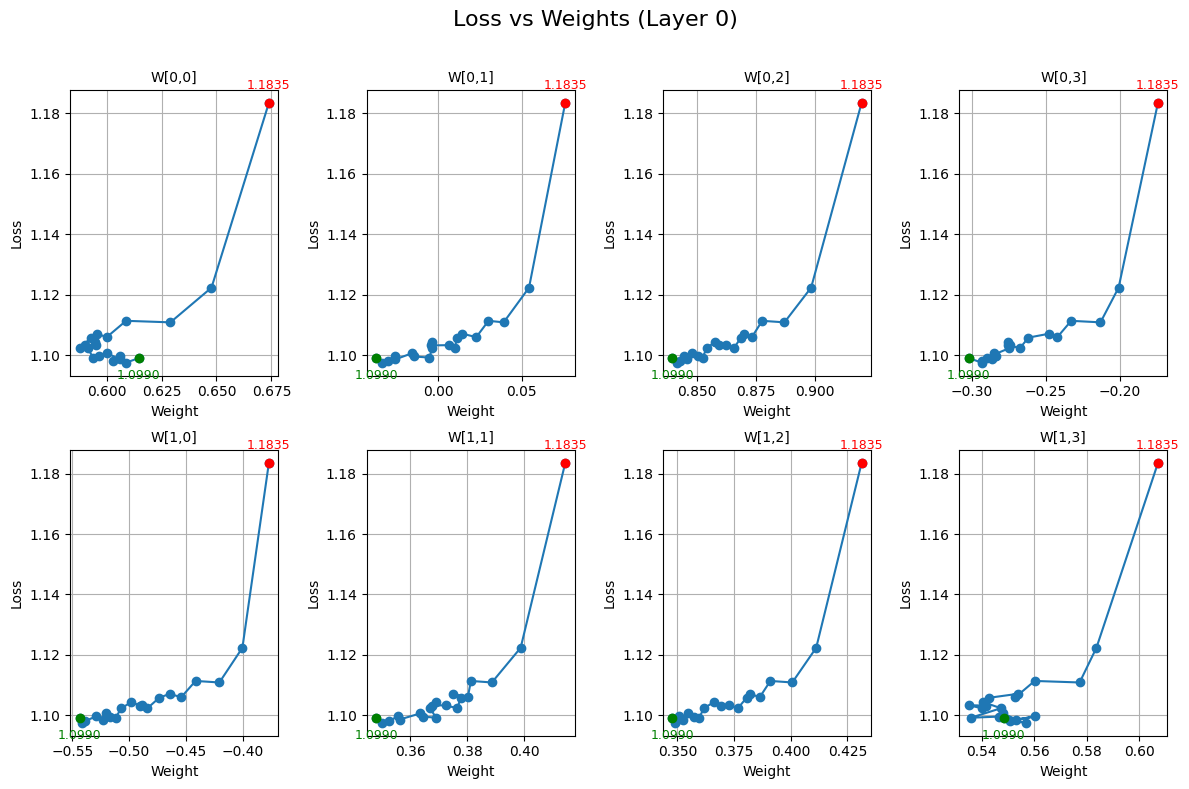

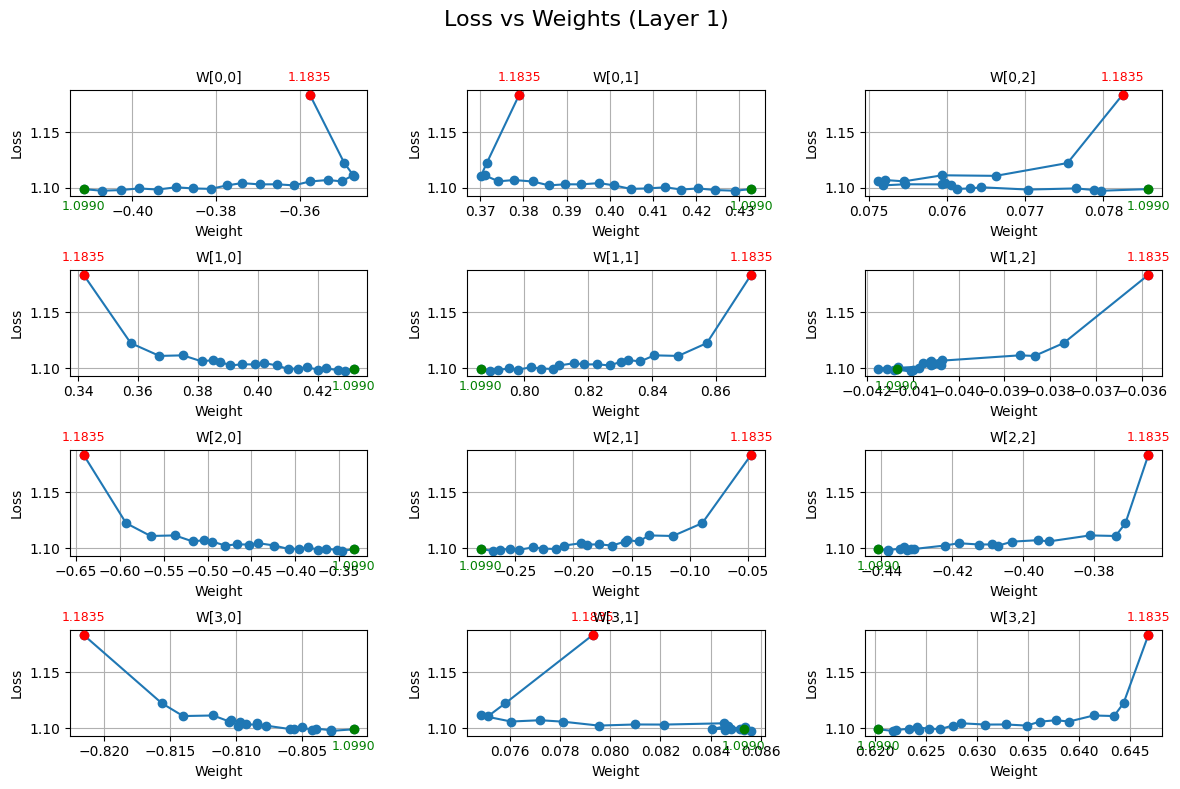

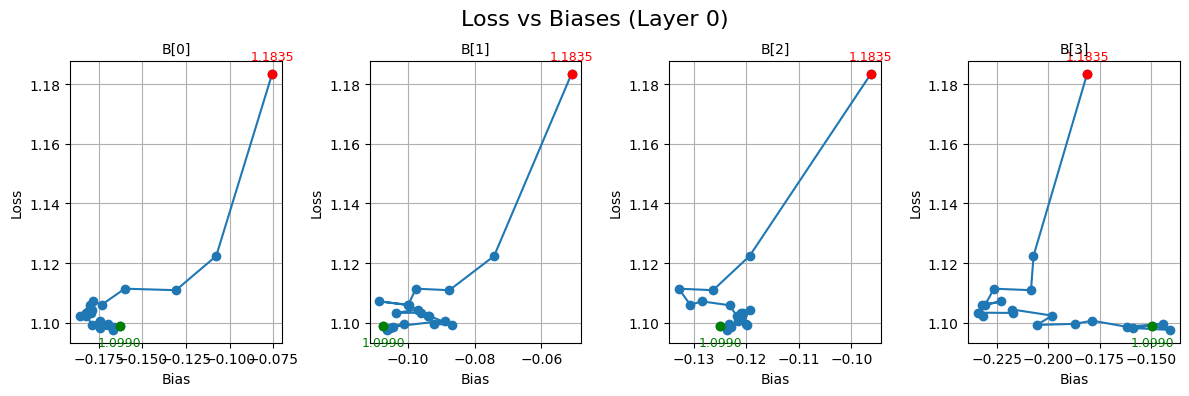

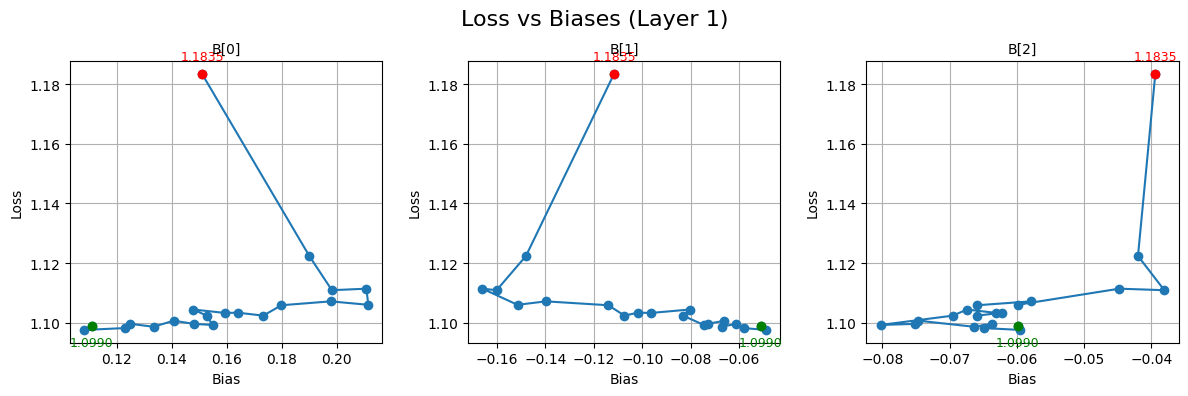

In [45]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback

# Step 1: Create the model
model = Sequential([
    Dense(4, input_dim=2, activation='relu'),  # Input: 2, Hidden: 4
    Dense(3, activation='softmax')            # Output: 3
])

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.1), loss='categorical_crossentropy')

# Step 2: Custom Callback to track weights, biases, and loss
class GradientTrackerCallback(Callback):
    def __init__(self):
        self.weight_trajectories = {}  # Store weight updates
        self.bias_trajectories = {}    # Store bias updates
        self.losses = []               # Store loss per epoch

    def on_train_begin(self, logs=None):
        for i, layer in enumerate(self.model.layers):
            if isinstance(layer, Dense):
                self.weight_trajectories[i] = []
                self.bias_trajectories[i] = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        for i, layer in enumerate(self.model.layers):
            if isinstance(layer, Dense):
                weights, biases = layer.get_weights()
                self.weight_trajectories[i].append(weights.copy())
                self.bias_trajectories[i].append(biases.copy())

# Instantiate the callback
gradient_callback = GradientTrackerCallback()

# Step 3: Generate synthetic training data
np.random.seed(42)
x = np.random.rand(100, 2)  # 100 samples, 2 features
y = np.random.randint(0, 3, size=(100,))  # 100 samples, 3 classes
y = np.eye(3)[y]  # One-hot encoding

# Train the model
model.fit(x, y, epochs=20, batch_size=10, verbose=0, callbacks=[gradient_callback])

# Step 4: Function to plot weights and biases as matrix grids with start and end loss markers
def plot_weight_bias_gradients_matrix(callback):
    weight_trajectories = callback.weight_trajectories
    bias_trajectories = callback.bias_trajectories
    losses = callback.losses

    # Plot weights as a matrix grid
    for layer_idx, weight_updates in weight_trajectories.items():
        weights_array = np.array(weight_updates)  # Convert to numpy array
        num_rows, num_cols = weights_array[0].shape  # Get weight matrix shape for the layer

        fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
        fig.suptitle(f"Loss vs Weights (Layer {layer_idx})", fontsize=16)

        for i in range(num_rows):
            for j in range(num_cols):
                ax = axes[i, j] if num_rows > 1 else axes[j]  # Handle 1D case
                weight_trajectory = weights_array[:, i, j]  # Extract weight updates for this position
                ax.plot(weight_trajectory, losses[:len(weight_trajectory)], marker='o')
                
                # Mark start and end loss
                ax.scatter(weight_trajectory[0], losses[0], color='red', label="Start Loss", zorder=5)
                ax.scatter(weight_trajectory[-1], losses[-1], color='green', label="End Loss", zorder=5)
                
                # Add annotations for start and end loss
                ax.annotate(f"{losses[0]:.4f}", (weight_trajectory[0], losses[0]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='red')
                ax.annotate(f"{losses[-1]:.4f}", (weight_trajectory[-1], losses[-1]), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=9, color='green')

                ax.set_title(f"W[{i},{j}]", fontsize=10)
                ax.set_xlabel("Weight")
                ax.set_ylabel("Loss")
                ax.grid(True)

        plt.tight_layout()
        plt.subplots_adjust(top=0.88)  # Adjust for title
        plt.show()

    # Plot biases as a matrix grid
    for layer_idx, bias_updates in bias_trajectories.items():
        biases_array = np.array(bias_updates)  # Convert to numpy array
        num_biases = biases_array.shape[1]  # Number of biases in this layer

        fig, axes = plt.subplots(1, num_biases, figsize=(12, 4))
        fig.suptitle(f"Loss vs Biases (Layer {layer_idx})", fontsize=16)

        for i in range(num_biases):
            ax = axes[i] if num_biases > 1 else axes  # Handle single bias case
            bias_trajectory = biases_array[:, i]  # Extract bias updates for this position
            ax.plot(bias_trajectory, losses[:len(bias_trajectory)], marker='o')
            
            # Mark start and end loss
            ax.scatter(bias_trajectory[0], losses[0], color='red', label="Start Loss", zorder=5)
            ax.scatter(bias_trajectory[-1], losses[-1], color='green', label="End Loss", zorder=5)
            
            # Add annotations for start and end loss
            ax.annotate(f"{losses[0]:.4f}", (bias_trajectory[0], losses[0]), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=9, color='red')
            ax.annotate(f"{losses[-1]:.4f}", (bias_trajectory[-1], losses[-1]), textcoords="offset points", xytext=(0, -15), ha='center', fontsize=9, color='green')

            ax.set_title(f"B[{i}]", fontsize=10)
            ax.set_xlabel("Bias")
            ax.set_ylabel("Loss")
            ax.grid(True)

        plt.tight_layout()
        plt.subplots_adjust(top=0.85)  # Adjust for title
        plt.show()

# Step 5: Plot the weight and bias gradients with start and end loss marked
plot_weight_bias_gradients_matrix(gradient_callback)
